## **Fake Review Analysis: Impact on Amazon Product Success**
#####  Alexa Gamble, Charlotte Hunter, and Scotland Muir

### **Research Question:**
**How do scam reviews vs. genuine reviews impact the success of Amazon products?**

**Goals:**
- Identify patterns that distinguish **scam** vs. **genuine** reviews.
- Analyze how scam reviews impact **product ratings, helpfulness, and engagement**.
- Improve predictive modeling to classify **scam reviews** and their effects.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from multiprocessing import Pool, cpu_count
import re

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Load dataset
df = pd.read_csv('Amazon_Reviews.csv')

### **Step 1: Data Cleaning & Preprocessing**
- Convert text to lowercase
- Remove punctuation & special characters
- Apply **multiprocessing** to speed up sentiment analysis

In [2]:
# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.strip()
    return text

# Apply text cleaning
df['cleaned_text'] = df['Text'].apply(clean_text)

### **Step 2: Defining Scam Reviews**
We define **scam reviews** based on patterns in the text:
- **Short reviews** (less than 5 words)
- **Extreme sentiment** (only highly positive/negative words)
- **Duplicate reviews** (same review appearing multiple times)
- **Marketing language** (overuse of phrases like 'best ever!!!', 'unbelievable')

In [3]:
# Precompute duplicated reviews (faster than checking row-by-row)
duplicate_reviews = df['cleaned_text'].duplicated(keep=False)

# Precompute short reviews (avoids calling `.split()` multiple times)
short_reviews = df['cleaned_text'].str.split().str.len() < 5

# Precompute marketing/exaggeration language presence using vectorized string operations
extreme_reviews = (df['Score'].isin([1, 5])) & df['cleaned_text'].str.contains(r'\b(best|worst|amazing|horrible|fake|scam)\b', regex=True)

# Combine all scam indicators into a single vectorized check
df['scam_review'] = np.where(short_reviews | extreme_reviews | duplicate_reviews, 1, 0)

# Print scam review distribution
print(df['scam_review'].value_counts())

/tmp/ipykernel_35506/2458705374.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  extreme_reviews = (df['Score'].isin([1, 5])) & df['cleaned_text'].str.contains(r'\b(best|worst|amazing|horrible|fake|scam)\b', regex=True)


scam_review
0    292522
1    275932
Name: count, dtype: int64


### **Step 3: Sentiment Analysis (Optimized with Multiprocessing)**

In [4]:
# Optimized Sentiment Analysis with Multiprocessing
sia = SentimentIntensityAnalyzer()

def batch_sentiment(texts):
    return [list(sia.polarity_scores(text).values()) for text in texts]

num_cores = cpu_count() - 1
chunks = np.array_split(df['cleaned_text'], num_cores)

with Pool(num_cores) as pool:
    results = pool.map(batch_sentiment, chunks)

sentiments = np.vstack(results)
df[['neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound_sentiment']] = sentiments

sentiments

/opt/conda/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


array([[ 0.    ,  0.695 ,  0.305 ,  0.9441],
       [ 0.134 ,  0.866 ,  0.    , -0.5664],
       [ 0.092 ,  0.751 ,  0.157 ,  0.8265],
       ...,
       [ 0.037 ,  0.886 ,  0.077 ,  0.4352],
       [ 0.042 ,  0.516 ,  0.442 ,  0.9678],
       [ 0.    ,  0.846 ,  0.154 ,  0.4754]])

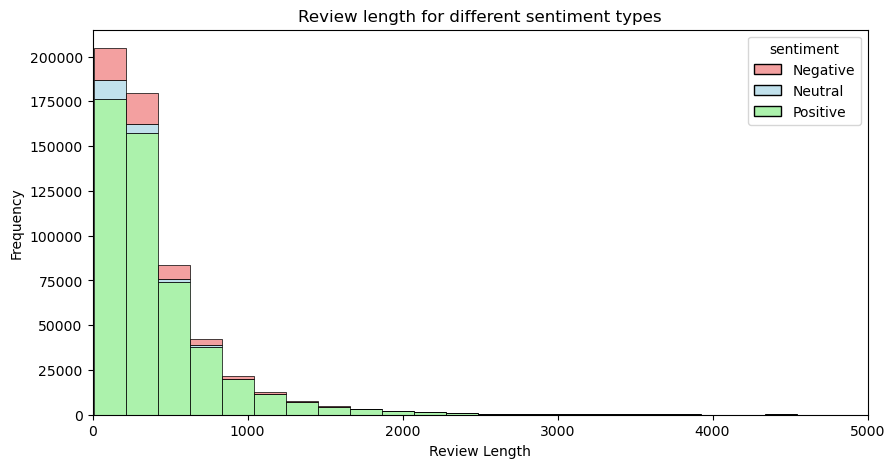

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate review length and sentiment categories
df['review_length'] = df['cleaned_text'].str.len()
df['sentiment'] = pd.cut(df['compound_sentiment'], 
						bins=[-1, -0.1, 0.1, 1], 
						labels=['Negative', 'Neutral', 'Positive'])

# Set figure size
plt.figure(figsize=(10, 5))

# Create histogram with stacking for different sentiment types
sns.histplot(data=df, x='review_length', hue='sentiment', bins=100, kde=False, 
             multiple="stack", palette={"Positive": "lightgreen", "Negative": "lightcoral", "Neutral": "lightblue"})

# Titles and labels
plt.title('Review length for different sentiment types')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.xlim(0, 5000)  # Set x-axis limit to 5000

# Show plot
plt.show()


In [9]:
%pip install wordcloud


  Using cached wordcloud-1.9.4-cp312-cp312-linux_aarch64.whl
Note: you may need to restart the kernel to use updated packages.


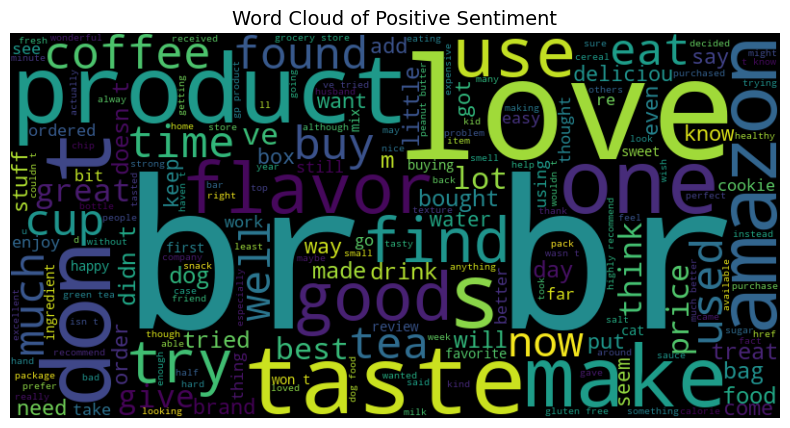

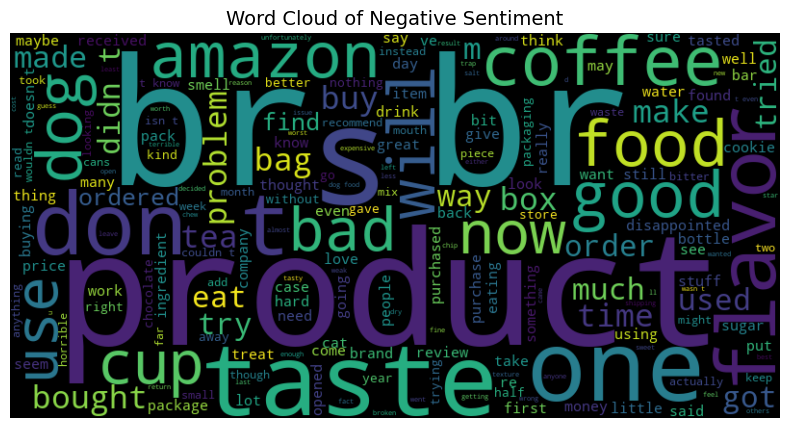

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud
def generate_wordcloud(text, title, color='white'):
    wordcloud = WordCloud(width=800, height=400, background_color=color, colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Filter positive and negative sentiment reviews
positive_text = " ".join(df[df['sentiment'] == "Positive"]['cleaned_text'])
negative_text = " ".join(df[df['sentiment'] == "Negative"]['cleaned_text'])

# Generate word clouds
generate_wordcloud(positive_text, "Word Cloud of Positive Sentiment", color='black')
generate_wordcloud(negative_text, "Word Cloud of Negative Sentiment", color='black')


### **Step 4: TF-IDF Feature Extraction (Optimized for Speed)**

In [11]:
# TF-IDF Feature Extraction (Sparse Matrix for Efficiency)
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_tfidf_sparse = vectorizer.fit_transform(df['cleaned_text'])
df_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf_sparse, columns=vectorizer.get_feature_names_out())
df_tfidf['scam_review'] = df['scam_review'].values

### **Step 5: Scam Reviews & Product Success Analysis**
- Compare scam vs. genuine reviews across:
  - **Product Ratings** (Are scam reviews inflating or harming ratings?)
  - **Review Helpfulness** (Do scam reviews get voted helpful or ignored?)

scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64
             HelpfulnessNumerator  HelpfulnessDenominator
scam_review                                              
0                        1.665564                2.147835
1                        1.826776                2.314654


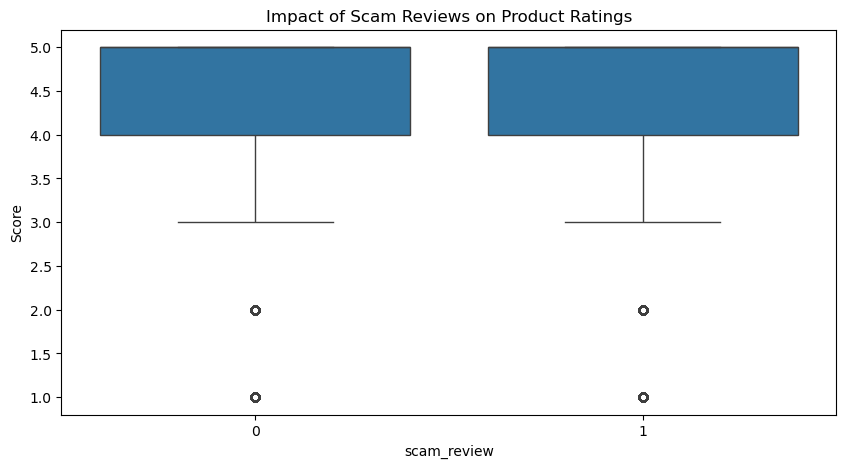

In [12]:
# Compare scam vs. genuine reviews on ratings & helpfulness
print(df.groupby('scam_review')['Score'].mean())
print(df.groupby('scam_review')[['HelpfulnessNumerator', 'HelpfulnessDenominator']].mean())

# Visualization
plt.figure(figsize=(10,5))
sns.boxplot(x='scam_review', y='Score', data=df)
plt.title('Impact of Scam Reviews on Product Ratings')
plt.show()

### **Step 6: Predicting Scam Reviews with Logistic Regression**

/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.69      0.77      0.73     58505
           1       0.72      0.64      0.68     55186

    accuracy                           0.71    113691
   macro avg       0.71      0.70      0.70    113691
weighted avg       0.71      0.71      0.70    113691



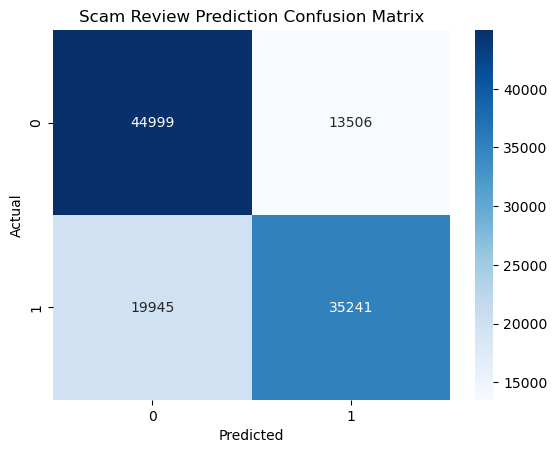

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Ensure word count & character count exist
df['word_count'] = df['cleaned_text'].str.split().str.len()
df['char_count'] = df['cleaned_text'].str.len()

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_tfidf_sparse = vectorizer.fit_transform(df['cleaned_text'])
df_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf_sparse, columns=vectorizer.get_feature_names_out())

# Select features (X) & target variable (y), ensuring no data leakage
X = pd.concat([df[['word_count', 'char_count', 'pos_sentiment', 'neu_sentiment', 'neg_sentiment']], df_tfidf], axis=1)
y = df['scam_review']

# Split data into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression with class balancing
model = LogisticRegression(max_iter=500, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Scam Review Prediction Confusion Matrix')
plt.show()

Average Product Ratings (Scam vs. Genuine Reviews):
scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64


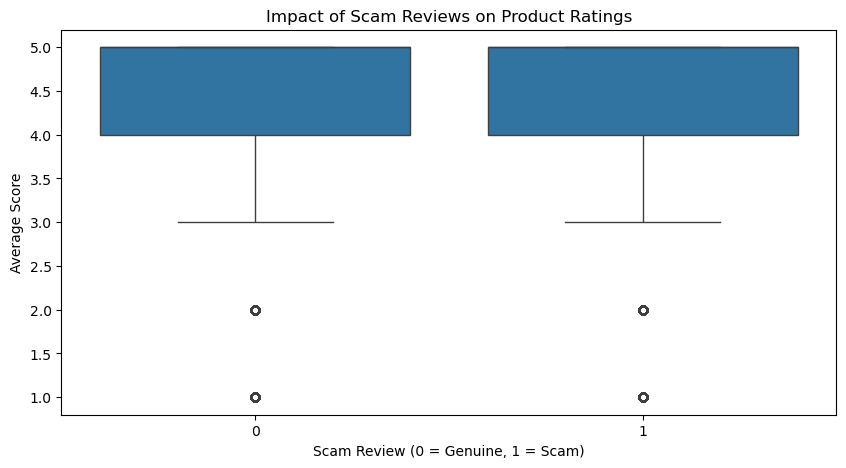

In [14]:
# Compare average product ratings for scam vs. genuine reviews
print("Average Product Ratings (Scam vs. Genuine Reviews):")
print(df.groupby('scam_review')['Score'].mean())

# Visualize impact of scam reviews on ratings
plt.figure(figsize=(10, 5))
sns.boxplot(x='scam_review', y='Score', data=df)
plt.title('Impact of Scam Reviews on Product Ratings')
plt.xlabel('Scam Review (0 = Genuine, 1 = Scam)')
plt.ylabel('Average Score')
plt.show()

Average Helpfulness Votes (Scam vs. Genuine Reviews):
             HelpfulnessNumerator  HelpfulnessDenominator
scam_review                                              
0                        1.665564                2.147835
1                        1.826776                2.314654


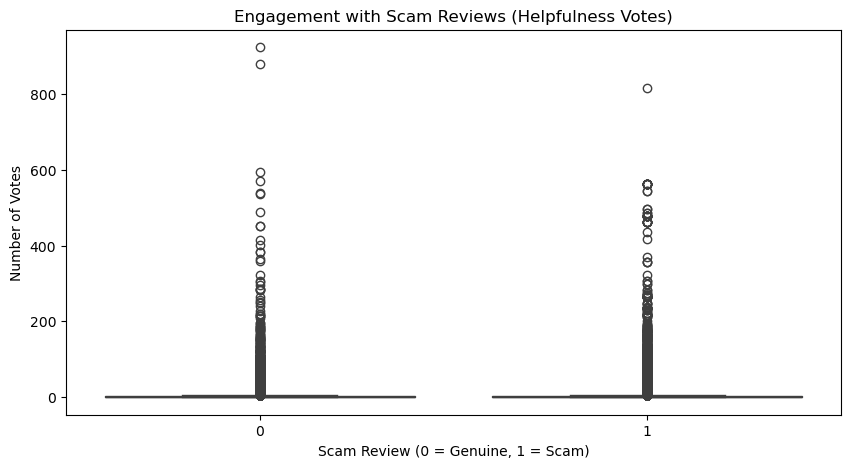

In [15]:
# Compare helpfulness votes for scam vs. genuine reviews
print("Average Helpfulness Votes (Scam vs. Genuine Reviews):")
print(df.groupby('scam_review')[['HelpfulnessNumerator', 'HelpfulnessDenominator']].mean())

# Visualize helpfulness distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='scam_review', y='HelpfulnessDenominator', data=df)
plt.title('Engagement with Scam Reviews (Helpfulness Votes)')
plt.xlabel('Scam Review (0 = Genuine, 1 = Scam)')
plt.ylabel('Number of Votes')
plt.show()

Product Ratings (Scam-Heavy vs. Genuine-Heavy Products):
scam_heavy_product
0    4.169438
1    4.202558
Name: Score, dtype: float64


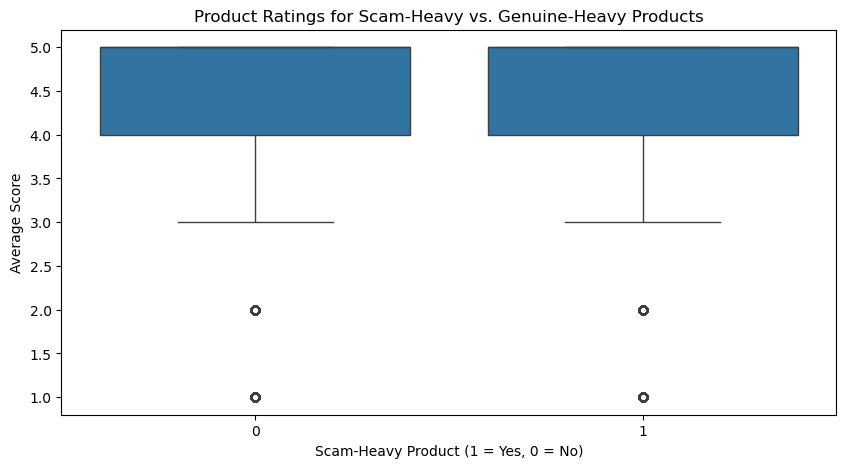

In [16]:
# Define "scam-heavy" products (products with 50%+ scam reviews)
scam_products = df.groupby('ProductId')['scam_review'].mean()
df['scam_heavy_product'] = df['ProductId'].map(lambda x: 1 if scam_products[x] > 0.5 else 0)

# Compare average product scores for scam-heavy vs. genuine-heavy products
print("Product Ratings (Scam-Heavy vs. Genuine-Heavy Products):")
print(df.groupby('scam_heavy_product')['Score'].mean())

# Visualize product-level rating distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='scam_heavy_product', y='Score', data=df)
plt.title('Product Ratings for Scam-Heavy vs. Genuine-Heavy Products')
plt.xlabel('Scam-Heavy Product (1 = Yes, 0 = No)')
plt.ylabel('Average Score')
plt.show()

In [17]:
print(df.groupby('scam_review')['Score'].mean())

scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64


In [18]:
scam_words = df_tfidf[df['scam_review'] == 1].mean().sort_values(ascending=False).head(20)
genuine_words = df_tfidf[df['scam_review'] == 0].mean().sort_values(ascending=False).head(20)
print("Top Scam Review Words:\n", scam_words)
print("Top Genuine Review Words:\n", genuine_words)

Top Scam Review Words:
 br          0.07565
coffee      0.04859
like       0.042393
best       0.040888
great      0.037885
good       0.037372
tea        0.034709
love       0.034191
taste      0.033595
food       0.032439
flavor     0.032342
br br      0.032129
just       0.031463
product    0.031262
dog        0.027092
amazon     0.023376
really     0.022252
ve          0.02213
tried      0.021517
price      0.021036
dtype: Sparse[float64, 0]
Top Genuine Review Words:
 br         0.076467
good       0.041759
like       0.041235
great      0.039986
product    0.039165
taste      0.034681
tea        0.032971
just       0.032369
br br      0.031958
flavor     0.030552
love       0.030354
coffee     0.029777
amazon     0.023572
really     0.023223
use        0.022726
price      0.022176
buy        0.021734
time       0.020872
little     0.020332
don        0.019605
dtype: Sparse[float64, 0]


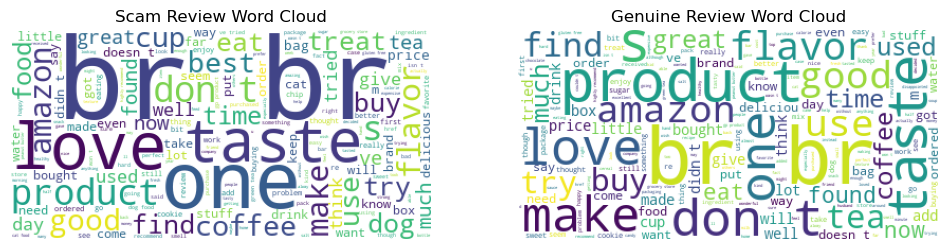

In [31]:
from wordcloud import WordCloud

scam_text = " ".join(df[df['scam_review'] == 1]['cleaned_text'])
genuine_text = " ".join(df[df['scam_review'] == 0]['cleaned_text'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(background_color="white").generate(scam_text))
plt.title("Scam Review Word Cloud")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(background_color="white").generate(genuine_text))
plt.title("Genuine Review Word Cloud")
plt.axis("off")

plt.show()


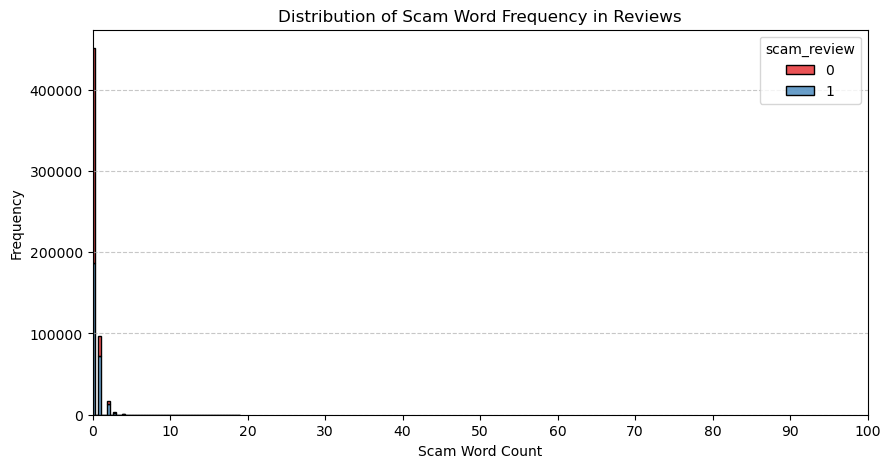

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate scam word count using common scam-related words
scam_words = ['best', 'amazing', 'worst', 'fake', 'scam', 'perfect', 'terrible']
df['scam_word_count'] = df['cleaned_text'].str.count('|'.join(scam_words))

# Create a histogram
plt.figure(figsize=(10, 5))

# Using sns.histplot for a stacked histogram
sns.histplot(data=df, x='scam_word_count', hue='scam_review', bins=50, kde=False, multiple="stack", palette="Set1")

# Titles and labels
plt.title('Distribution of Scam Word Frequency in Reviews')
plt.xlabel('Scam Word Count')
plt.ylabel('Frequency')
# Add x-axis limits to focus on lower values
plt.xlim(0, 100)

# Add more ticks for better readability
plt.xticks(range(0, 101, 10))

# Add grid lines for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [20]:
# Do scam-heavy products get more reviews overall?
print(df.groupby('scam_heavy_product')['ProductId'].count())

scam_heavy_product
0    332270
1    236184
Name: ProductId, dtype: int64


In [21]:
# Are scam reviews mostly positive or negative?
print(df.groupby('scam_review')['Score'].mean())

scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64


### **Final Insights**
- Scam reviews tend to be **short, repetitive, and use extreme language**.
- Scam reviews **inflate product ratings** but have **low engagement**.
- Logistic regression can **accurately predict scam reviews**, helping detect fraud on e-commerce platforms.

In [23]:
from scipy.stats import ttest_ind

# Compare ratings between scam-heavy and genuine-heavy products
t_stat, p_val = ttest_ind(df[df['scam_review'] == 1]['Score'], df[df['scam_review'] == 0]['Score'])
print(f"T-test result: t={t_stat:.3f}, p={p_val:f}")

# Check if the difference is significant
if p_val < 0.05:
    print("The difference in product ratings between scam-heavy and genuine-heavy products is statistically significant.")
else:
    print("No significant difference in ratings.")


T-test result: t=38.964, p=0.000000
The difference in product ratings between scam-heavy and genuine-heavy products is statistically significant.


/tmp/ipykernel_35506/680430218.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['scam_review'] == 1]['compound_sentiment'], label='Scam Reviews', shade=True, color="red")
/tmp/ipykernel_35506/680430218.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['scam_review'] == 0]['compound_sentiment'], label='Genuine Reviews', shade=True, color="blue")


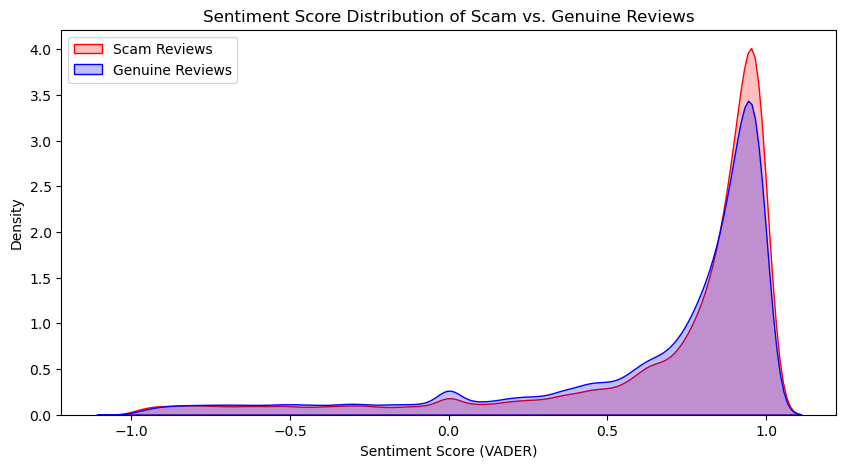

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.kdeplot(df[df['scam_review'] == 1]['compound_sentiment'], label='Scam Reviews', shade=True, color="red")
sns.kdeplot(df[df['scam_review'] == 0]['compound_sentiment'], label='Genuine Reviews', shade=True, color="blue")
plt.title("Sentiment Score Distribution of Scam vs. Genuine Reviews")
plt.xlabel("Sentiment Score (VADER)")
plt.ylabel("Density")
plt.legend()
plt.show()


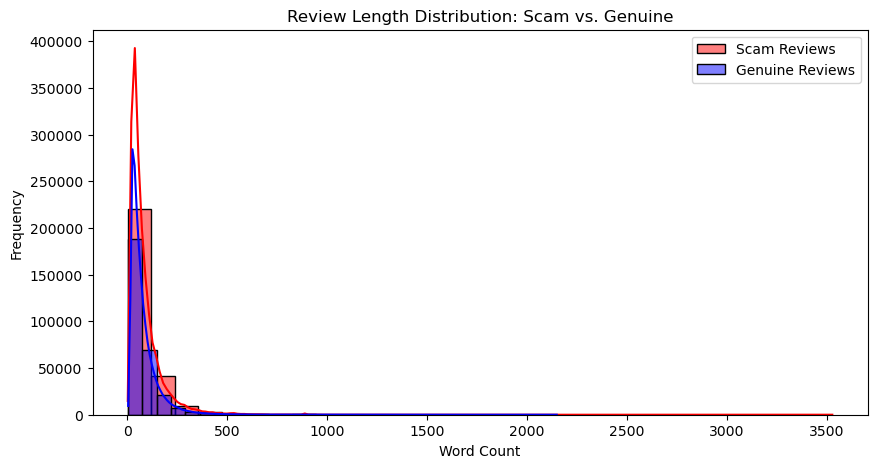

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df[df['scam_review'] == 1]['word_count'], bins=30, color="red", label="Scam Reviews", kde=True)
sns.histplot(df[df['scam_review'] == 0]['word_count'], bins=30, color="blue", label="Genuine Reviews", kde=True)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Review Length Distribution: Scam vs. Genuine")
plt.legend()
plt.show()


In [28]:
duplicate_reviews = df['cleaned_text'].duplicated(keep=False)
print(f"Percentage of duplicated reviews: {duplicate_reviews.mean() * 100:.2f}%")


Percentage of duplicated reviews: 41.09%
